### In this project, we would explore regression analysis and make predictions on used car prices using an ensemble of regressors. After that, we would build a web app for user interactions and live predictions.
---
1. *In Part I of the project we pre-processed the data*
2. #### This is PART II of the project where we focus on regression methods and building an ensemble of them for used car prices prediction

#### Highlights of this part:
1.  Regression methods
2.  Building ensemble of regressors from scratch

**Citations:**

This dataset is from Kaggle - Used Cars Dataset

URL: https://www.kaggle.com/austinreese/craigslist-carstrucks-data

---

The following description is from Kaggle:

**Context**

Craigslist is the world's largest collection of used vehicles for sale, yet it's very difficult to collect all of them in the same place. I built a scraper for a school project and expanded upon it later to create this dataset which includes every used vehicle entry within the United States on Craigslist.

**Content**

This data is scraped every few months, it contains most all relevant information that Craigslist provides on car sales including columns like price, condition, manufacturer, latitude/longitude, and 18 other categories. For ML projects, consider feature engineering on location columns such as long/lat. For previous listings, check older versions of the dataset.

See https://github.com/AustinReese1998/craigslistFilter

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Load dataset generated from Part I
df = pd.read_csv('Data/vehicles_pre-processed.csv')

In [3]:
df.head()

,price,year,manufacturer,model,fuel,odometer,title_status,transmission,state
0,10299,2012.0,acura,Others,gas,90186.0,clean,automatic,nc
1,3995,2004.0,honda,Others,gas,212526.0,clean,automatic,nc
2,12995,2015.0,kia,sportage,gas,85127.0,clean,automatic,nc
3,10995,2014.0,chevrolet,traverse,gas,112383.0,clean,automatic,nc
4,8995,2011.0,bmw,Others,gas,124446.0,clean,automatic,nc


We could do some visualizations on the data, for example the following. I would create another demonstration solely on data visualizations. For now, let's focus on the objective of predicting used car prices.

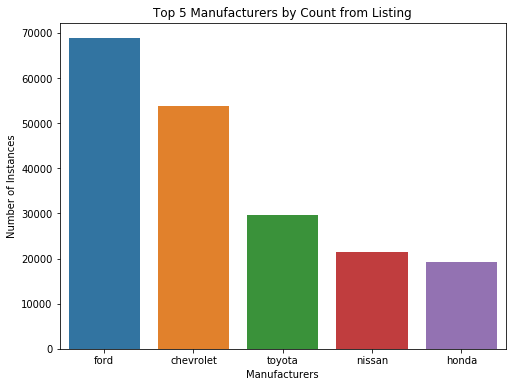

In [4]:
mc = df['manufacturer'].value_counts().head()
plt.figure(figsize = (8, 6))
sns.barplot(x = mc.index, y = mc.values)
plt.title('Top 5 Manufacturers by Count from Listing')
plt.xlabel('Manufacturers')
plt.ylabel('Number of Instances')
plt.show()

#### Before we fit the data using regression models, we would like to standardize the numerical features and one-hot encode the categorical features. For detailed explanations on the methods, please refer to the Portfolio Project 1: Predictive Analysis Structure - Hotel Booking Classification

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

In [6]:
#Build Feature_Selector class
class FeatureSelector(BaseEstimator, TransformerMixin):
    '''
    Select certain features from a Dataframe, return numpy array
    '''
    def __init__(self, columns):
        '''
        columns: list of columns
        '''
        self.columns = columns
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        return X.loc[:, self.columns].values.reshape(-1, len(self.columns))

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368574 entries, 0 to 368573
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         368574 non-null  int64  
 1   year          368574 non-null  float64
 2   manufacturer  368574 non-null  object 
 3   model         368574 non-null  object 
 4   fuel          368574 non-null  object 
 5   odometer      368574 non-null  float64
 6   title_status  368574 non-null  object 
 7   transmission  368574 non-null  object 
 8   state         368574 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 25.3+ MB


In [8]:
#StandardScaler and OneHotEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
#Build Transformer Pipelines
from sklearn.pipeline import make_pipeline, make_union

cat_fs = FeatureSelector(['manufacturer', 'model', 'fuel', 'title_status', 'transmission', 'state'])
num_fs = FeatureSelector(['year', 'odometer']) # We treat year column as numeric

cat_trans = make_pipeline(cat_fs, OneHotEncoder(drop = 'first', sparse = False))
num_trans = make_pipeline(num_fs, StandardScaler())

union_trans = make_union(cat_trans, num_trans)

#### We would start from fitting a Random Forest Regression model. Again, all details on reasons behind each individual steps could be found in Portfolio Project 1: Predictive Analysis Structure - Hotel Booking Classification

In [9]:
X = df.drop(['price'], axis = 1)
y = df['price'].values

In [10]:
from sklearn.model_selection import train_test_split

X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size = 0.2)

In [11]:
#Further split train_all into training and cross validation sets since we do not want to touch the test set yet
X_train, X_cv, y_train, y_cv = train_test_split(X_train_all, y_train_all, test_size = 0.1)

In [12]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_jobs = -1)
forest_pipe = make_pipeline(union_trans, forest)

In [13]:
#Now fit the data and make predictions
forest_pipe.fit(X_train, y_train)
pred_cv = forest_pipe.predict(X_cv)

#### Now we can evaluate the model performance, for performance evaluation for regression, we would use the following methods:
1. Residual plot
2. Mean squared error (MSE)
3. R-squared

Text(0.5, 1.0, 'Residual Plot')

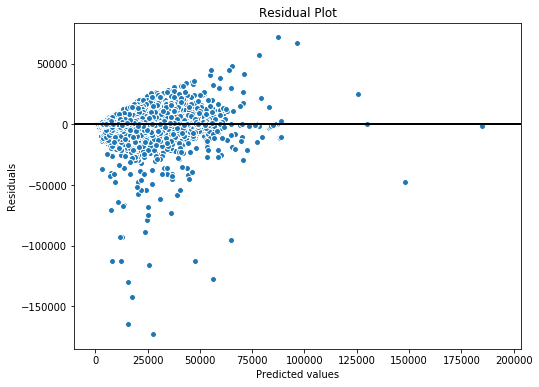

In [24]:
#Residual plot
plt.figure(figsize = (8, 6))
plt.scatter(pred_cv, pred_cv - y_cv, edgecolor = 'white')
plt.hlines(y = 0, xmin = -10000, xmax = pred_cv.max() * 1.1, color = 'black', lw = 2)
plt.xlim(-10000, pred_cv.max() * 1.1)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot')